**Outline:**

1. [Libraries and settings](#1-bullet)
2. [Nested CV](#2-bullet)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. [Libraries and settings](#1-bullet)

In [ ]:
from DataPreprocessing import *

<class 'pandas.core.frame.DataFrame'>
Index: 1733 entries, 0 to 1732
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         1733 non-null   float64
 1   High         1733 non-null   float64
 2   Low          1733 non-null   float64
 3   Close        1733 non-null   float64
 4   Volume       1733 non-null   int64  
 5   TradingDate  1733 non-null   object 
 6   Code         1733 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 108.3+ KB


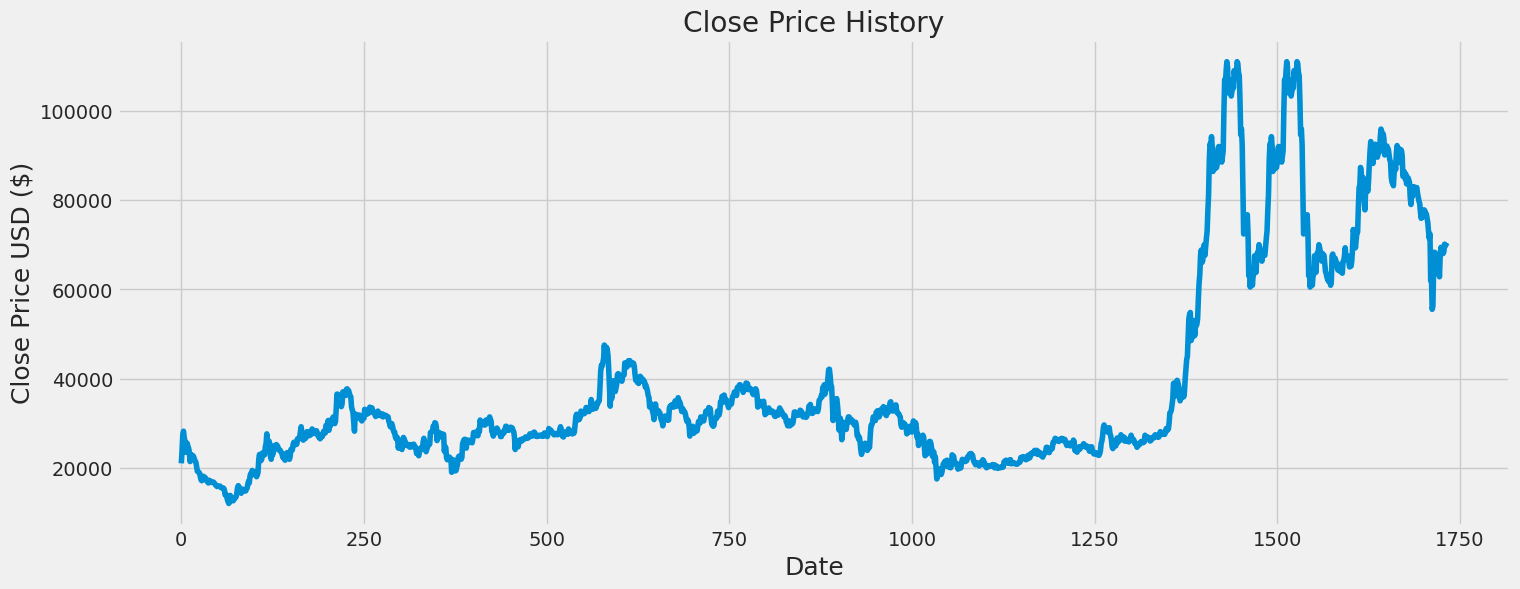

array([[-0.78011689],
       [-0.65238054],
       [-0.49821598],
       ...,
       [ 1.36497282],
       [ 1.37818693],
       [ 1.39580573]])

In [ ]:
#!/usr/bin/env python
# coding: utf-8

# ## Import Libraries

# In[1]:


import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime as dt

from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import learning_curve, train_test_split

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from tqdm import tqdm

import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
get_ipython().run_line_magic('matplotlib', 'inline')

import warnings
warnings.filterwarnings("ignore")


# ## Load dataset

# In[2]:


df = pd.read_csv('/content/drive/MyDrive/VietFinanceLab-Analyzing-Market-Trends-and-Forecasting-Future-Price/Dataset/technology/VGI.csv', sep='\t', index_col=0)


# In[3]:


df.head()


# In[4]:


df.info()


# In[5]:


df.describe()


# ## Data Cleaning

# In[6]:


df['TradingDate'] = pd.to_datetime(df['TradingDate'], format='%Y-%m-%d')


# In[7]:


df = df.dropna()


# ## Data Visualization

# In[8]:


plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()


# ## Manipulate data

# In[9]:


# Create a new dataframe
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values


# In[10]:


# scaler = MinMaxScaler(feature_range=(0,1))
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)

scaled_data


# In[ ]:






## 2. [Nested CV - Day Forward Chaining](#2-bullet)

We try to use nested CV for time series to try to tune hyperparameters. After getting best hyperparameters, we retrain model and then evaluate

### Create dataset

In [ ]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 30
x_for_train, y_for_train = create_dataset(scaled_data, time_step)

x_for_train = x_for_train.reshape(x_for_train.shape[0],x_for_train.shape[1])
y_for_train = y_for_train.reshape(y_for_train.shape[0],1)

### Day forward chaining

In [ ]:
def performXGBoost(X_train, Y_train, X_test, Y_test, parameters):

    XGBoost_model = XGBRegressor(n_estimators = parameters['n_estimators'], max_depth = parameters['max_depth'], learning_rate = parameters['learning_rate'])
    XGBoost_model.fit(X_train, Y_train, verbose=False)

    # Make predictions on the test set
    Y_pred_train = XGBoost_model.predict(X_train)
    Y_pred_test = XGBoost_model.predict(X_test)

    # Calculate accuracy
    accuracy_train = XGBoost_model.score(X_train, Y_train)
    accuracy_valid = XGBoost_model.score(X_test, Y_test)

    mse_train = mean_squared_error(Y_train, Y_pred_train)
    mse_valid = mean_squared_error(Y_test, Y_pred_test)

    return [accuracy_train, accuracy_valid, mse_train, mse_valid]

In [ ]:
from sklearn.model_selection import ParameterGrid

def performDayForwardChaining(X_train, y_train, number_folds):
    # Định nghĩa siêu tham số để tinh chỉnh
    param_grid = {
        'n_estimators': [100, 500, 1000],
        'max_depth': [3,6,10],
        'learning_rate' : [0.01, 0.05, 0.1]
    }

    # Chuyển đổi siêu tham số thành danh sách các tham số có thể
    param_list = list(ParameterGrid(param_grid))

    print('Size train set: ', X_train.shape)

    # k is the size of each fold. It is computed dividing the number of
    # rows in X_train by number_folds. This number is floored and coerced to int
    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: ', k)

    results_valid = []
    results_test = []
    # loop from the first 2 folds to the total number of folds
    for i in range(3, number_folds + 1):
        print('')

        split = float(i-1)/i

        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i))

        X = X_train[:(k*i),:]
        y = y_train[:(k*i),:]
        print('Size of train + valid + test: ', X.shape)

        index = int(np.floor(X.shape[0] * split))
        print(index)

        # folds used to train the model
        X_train_validFolds = X[:index,:]
        y_train_validFolds = y[:index,:]

        index_valid = int((i-2)*index/(i-1))

        X_trainFolds = X_train_validFolds[:index_valid,:]
        y_trainFolds = y_train_validFolds[:index_valid,:]

        X_validFolds = X_train_validFolds[index_valid:,:]
        y_validFolds = y_train_validFolds[index_valid:,:]

        # fold used to test the model
        X_testFolds = X[(index + 1):,:]
        y_testFolds = y[(index + 1):,:]

        for j,params in enumerate(param_list):
            print(f"Evaluating parameters {j+1}: {params}")
            accuracies_valid = performXGBoost(X_trainFolds, y_trainFolds, X_validFolds, y_validFolds, params)

            results_valid.append({
            'parameters': params,
            'accuracy_train': accuracies_valid[0],
            'accuracy_valid': accuracies_valid[1],
            'mse_train': accuracies_valid[2],
            'mse_valid': accuracies_valid[3]
            })

        for result in results_valid:
            print("Parameters: ", result['parameters'])
            print("Train Accuracy: ", result['accuracy_train'])
            print("Valid Accuracy: ", result['accuracy_valid'])
            print("Train MSE: ", result['mse_train'])
            print("Valid MSE: ", result['mse_valid'])
            print("------------------------")

        # Sắp xếp danh sách kết quả theo trường 'accuracy_valid' tăng dần
        sorted_results_valid = sorted(results_valid, key=lambda x: x['mse_valid'], reverse=False)

        # Lấy bộ tham số đầu tiên từ danh sách đã sắp xếp
        best_parameters = sorted_results_valid[0]['parameters']
        print(best_parameters)

        accuracies_test = performXGBoost(X_train_validFolds, y_train_validFolds, X_testFolds, y_testFolds, best_parameters)

        results_test.append({
            'parameters': best_parameters,
            'accuracy_train': accuracies_test[0],
            'accuracy_test': accuracies_test[1],
            'mse_train': accuracies_test[2],
            'mse_test': accuracies_test[3]
            })

    acc_train_model = 0
    acc_test_model = 0
    mse_train_model = 0
    mse_test_model = 0
    cnt = 0
    for result in results_test:
        acc_train_model += result['accuracy_train']
        acc_test_model += result['accuracy_test']
        mse_train_model += result['mse_train']
        mse_test_model += result['mse_test']
        cnt += 1

    acc_train_model = acc_train_model/cnt
    acc_test_model = acc_test_model/cnt
    mse_train_model = mse_train_model/cnt
    mse_test_model = mse_test_model/cnt
    # the function returns the mean of the accuracy on the n-1 folds
    return acc_train_model, acc_test_model, mse_train_model, mse_test_model

In [ ]:
accuracy_train_model, accuracy_test_model, mse_train_model, mse_test_model = performDayForwardChaining(x_for_train, y_for_train, number_folds=5)

print("Train MSE Model: ", mse_train_model)
print("Train Accuracy Model: ", accuracy_train_model)
print("Test MSE Model: ", mse_test_model)
print("Test Accuracy Model: ", accuracy_test_model)
print("------------------------")


Size train set:  (1702, 30)
Size of each fold:  340

Splitting the first 3 chunks at 2/3
Size of train + valid + test:  (1020, 30)
680
Evaluating parameters 1: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Evaluating parameters 2: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
Evaluating parameters 3: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000}
Evaluating parameters 4: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}
Evaluating parameters 5: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 500}
Evaluating parameters 6: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 1000}
Evaluating parameters 7: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100}
Evaluating parameters 8: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 500}
Evaluating parameters 9: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 1000}
Evaluating parameters 10: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100